## Rover Project Test Notebook
This notebook contains the functions that provide the scaffolding needed to test out mapping methods.  The following steps are taken to test functions and calibrate data for the project:

* The simulator is run in "Training Mode" and some data is recorded. Note: the simulator may crash if a large (longer than a few minutes) dataset is recorded; only a small data sample is required i.e. just some example images to work with.   
* The functions are tested with the data.
* Functions are written and modified to report and map out detections of obstacles and rock samples (yellow rocks).
* `process_image()` function is populated with the appropriate steps/functions to go from a raw image to a worldmap.
* `moviepy` functions are used to construct a video output from processed image data.
* Once it is confirmed that mapping is working, `perception.py` and `decision.py` are modified to allow the rover to navigate and map in autonomous mode!

*Note: If, at any point, display windows freeze up or other confounding issues are encountered, Kernel should be restarted and output cleared from the "Kernel" menu above.*

*Uncomment and run the next cell to get code highlighting in the markdown cells.*

In [1]:
#%%HTML
#<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window

import cv2  # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc  # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()


Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0106496/28549024 bytes (0.4335872/28549024 bytes (1.2565248/28549024 bytes (2.0827392/28549024 bytes (2.91073152/28549024 bytes (3.8%1335296/28549024 bytes (4.7%1581056/28549024 bytes (5.5%1826816/28549024 bytes (6.4%2072576/28549024 bytes (7.3%2301952/28549024 bytes (8.1%2514944/28549024 bytes (8.8%2695168/28549024 bytes (9.4%2924544/28549024 bytes (10.23121152/28549024 bytes (10.93350528/28549024 bytes (11.73514368/28549024 bytes (12.33743744/28549024 bytes (13.14071424/28549024 bytes (14.34349952/28549024 bytes (15.24628480/28549024 bytes (16.24890624/28549024 bytes (17.15169152/28549024 bytes (18.15464064/28549024 bytes (19.15726208/28549024 bytes (20.15906432/28549024 bytes (20.76053888/28549024 bytes (21.26299648/28549024 bytes (22.16512640/28549024 bytes (22.86

## Quick Look at the Data
Data can be found in the test_dataset folders. Additional data can be recorded to sample various scenarios in the simulator to hone perception methods more precisely.

Next, read in and display a random image from the test_dataset folder:

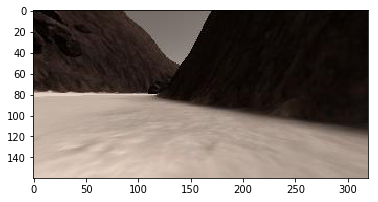

In [3]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)

# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images. The grid is used for perspective transform and the rock image for creating a new color selection that identifies these samples of interest.

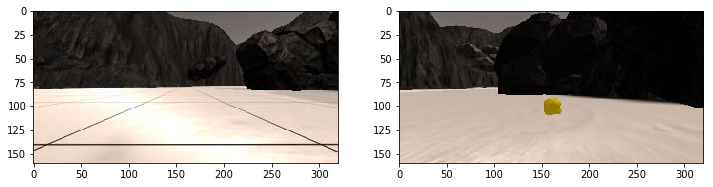

In [4]:
# In the simulator the grid on the ground can be toggled on for calibration.
# The rock samples can be toggled on with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

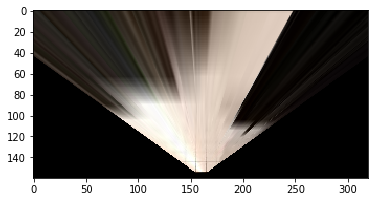

In [5]:
# The example grid image above is used to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
def perspect_transform(img, src, dst):
    """Define a function to perform a perspective transform."""
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(
        img,
        M,
        (img.shape[1], img.shape[0])  # keep same size as input image
    )
    return warped


# Define calibration box in source (actual) and destination (desired)
# coordinates to warp the image to a grid where each 10x10 pixel square
# represents 1 square meter and the destination box will be 2*dst_size
# on each side
dst_size = 5 

# Set a bottom offset (rough estimate) to account for the fact that the
# bottom of the image is not the position of the rover but a bit in front
# of it
bottom_offset = 6

source = np.float32(
    [[14, 140],
     [301 ,140],
     [200, 96],
     [118, 96]]
)
destination = np.float32(
    [
        [image.shape[1]/2 - dst_size,
         image.shape[0] - bottom_offset],

        [image.shape[1]/2 + dst_size,
         image.shape[0] - bottom_offset],

        [image.shape[1]/2 + dst_size,
         image.shape[0] - 2*dst_size - bottom_offset],

        [image.shape[1]/2 - dst_size,
         image.shape[0] - 2*dst_size - bottom_offset],
    ]
)
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Color Thresholding
Define the color thresholding function for navigable terrain and apply it to the warped image.

Ultimately, the map not only includes navigable terrain but also obstacles and the positions of the rock samples we're searching for. New functions are needed to return the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that these areas can be mapped into world coordinates as well. 

Changing colorspaces in OpenCV: [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html)

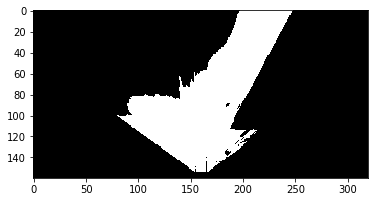

In [9]:
def color_thresh(input_img, rgb_thresh=(160, 160, 160)):
    """
    Identify pixels above the threshold.

    Threshold of RGB > 160 does a nice job of identifying ground pixels only

    """
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(input_img[:,:,0])

    # Require that each of the R(0), G(1), B(2) pixels be above all three
    # rgb_thresh values such that pix_above_thresh will now contain a
    # boolean array with "True" where threshold was met
    above_thresh = (
        (input_img[:, :, 0] > rgb_thresh[0]) &
        (input_img[:, :, 1] > rgb_thresh[1]) &
        (input_img[:, :, 2] > rgb_thresh[2])
    )
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1

    # Return the binary image
    return color_select


threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

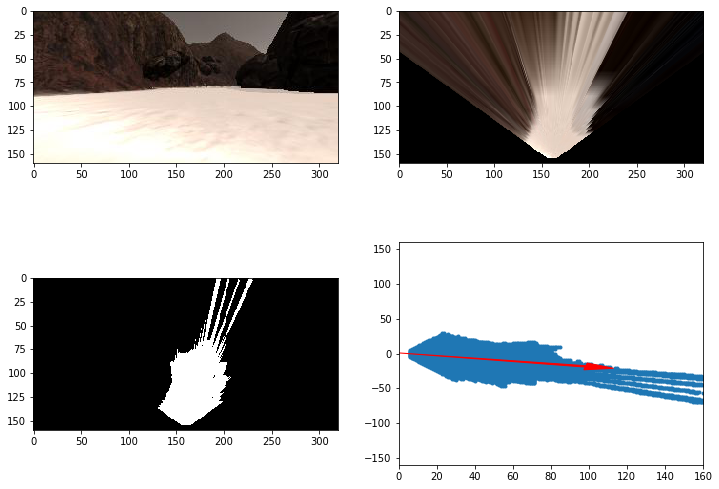

In [11]:
def rover_coords(binary_img):
    """Convert from image coords to rover coords."""
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position 
    # being at the center bottom of the image
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel


def to_polar_coords(x_pixel, y_pixel):
    """Convert to radial coords in rover space."""
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles


def rotate_pix(xpix, ypix, yaw):
    """Map rover space pixels to world space."""
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    return xpix_rotated, ypix_rotated


def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    """Apply a scaling and a translation."""
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    return xpix_translated, ypix_translated


def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    """
    Apply rotation and translation (and clipping).
    
    Note:
    Requires functions rotate_pix and translate_pix to work
    
    """
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(
        xpix_rot,
        ypix_rot,
        xpos, ypos,
        scale
    )
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)

    return x_pix_world, y_pix_world


# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)


## Read in saved data and ground truth map of the world
The next cell is all setup to read your saved data into a `pandas` dataframe.  Here you'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When you instantiate this class (`data = Databucket()`) you'll have a global variable called `data` that you can refer to for telemetry and map data within the `process_image()` function in the following cell.  


In [12]:
import pandas as pd  # read in csv file as a dataframe

# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist()  # Create list of image pathnames

# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack(
    (ground_truth*0,
     ground_truth*255,
     ground_truth*0)
).astype(np.float)


class Databucket():
    """
    Create a class to be a container of rover sensor data from sim.

    Reads in saved data from csv sensor log file generated by sim which
    includes saved locations of front camera snapshots and corresponding
    rover position and yaw values in world coordinate frame

    """

    def __init__(self):
        """
        Initialize a Databucket instance unique to a single simulation run.

        worldmap instance variable is instantiated with a size of 200 square
        grids corresponding to a 200 square meters space which is same size as
        the 200 square pixels ground_truth variable allowing full range
        of output position values in x and y from the sim

        """
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0  # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d  # Ground truth worldmap


# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()


## Write a function to process stored images

The `process_image()` function below is modified by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the rover camera image data taken in the simulator.  

In short, we will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of the output video. A mosaic of the various steps of above analysis process and additional text can also be added.  

The output video ultimately demonstrates our mapping process.

In [17]:
def process_image(img):
    """
    Pass stored images to reading rover position and yaw angle from csv file.
    
    Note:
    This function is used by moviepy to create an output video

    """
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    # 7) Make a mosaic image

    # First create a blank image (can be whatever shape)
    output_image = np.zeros(
        (img.shape[0] + data.worldmap.shape[0],
         img.shape[1]*2,
         3)
    )

    # Next you can populate regions of the image with various output
    # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

    # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)

    # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

    # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)

    # Flip map overlay so y-axis points upward and add to output_image
    output_image[
        img.shape[0]:,
        0:data.worldmap.shape[1]
    ] = np.flipud(map_add)

    # Then putting some text over the image
    cv2.putText(
        output_image,
        "Populate this image with your analyses to make a video!",
        (20, 20),
        cv2.FONT_HERSHEY_COMPLEX,
        0.4,
        (255, 255, 255),
        1
    )
    if data.count < len(data.images) - 1:
        data.count += 1  # Keep track of the index in the Databucket()

    return output_image

## Make a video from processed image data
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'

# Re-initialize data in case you're running this cell multiple times
data = Databucket()

# Note: output video will be sped up because recording rate 
# in simulator is fps=25
clip = ImageSequenceClip(data.images, fps=60) 
new_clip = clip.fl_image(process_image)  # NOTE: process_image expects color images!

%time new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|██████████| 283/283 [00:01<00:00, 190.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

CPU times: user 1.14 s, sys: 32 ms, total: 1.17 s
Wall time: 1.6 s


### The next cell functions as an inline video player
If this fails to render the video, the alternative video rendering method in the following cell can be run. The output video mp4 is saved in the /output folder.

In [19]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Below is an alternative way to create a video in case the above cell did not work.

In [20]:
import io
import base64

video = io.open(output, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))